In [7]:
%pip install numpy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [8]:
import numpy as np
import random

In [42]:

#Base class, any child classes should implement evolve and have a value
class Asset:
    def __init__(self, id, initialValue):
        self.value = initialValue
        self.initialValue = initialValue
        self.assetId = id
    def evolve(self):
        self.value = self.value

    def reset(self):
        self.value = self.initialValue

class Bond(Asset):
    #TODO: add conditions to ensure rate is valid``
    def __init__(self, id, initialValue, rate):
        self.rate = rate
        super().__init__(id, initialValue)
    def evolve(self):
        self.value = self.value * self.rate

class BinomialStock(Asset):
    def __init__(self, id, initialValue, u, d, p):
        self.u = u
        self.d = d
        self.p = p
        super().__init__(id, initialValue)
    def evolve(self):
        probDraw = random.random()
        if probDraw < self.p:
            self.value += self.u
        else:
            self.value += self.d
class Market:
    def __init__(self, assets):
        self.assets = assets
        self.time = 0
        self.history = []
        self.history.append(self.returnAssetValues())

    def returnAssetValues(self):
        values = []
        for asset in self.assets:
            values.append(asset.value)
        return values

    def evolve(self):
        for asset in self.assets:
            asset.evolve()
        self.history.append(self.returnAssetValues())
        self.time += 1

    def reset(self):
        self.time = 0
        self.history = []
        for asset in self.assets:
            asset.reset()
        self.history.append(self.returnAssetValues())

    def returnHistoricReturns(self):
        marketReturns = []
        #Guranteed to exist by initialistion method
        initialMarketValue = sum(self.history[0])
        for assetPrices in self.history:
            marketReturns.append(sum(assetPrices) - initialMarketValue)
        return marketReturns

    #Beta is the correlation between an asset's returns and the returns of the market as a whole
    def calculateHistoricBeta(self, assetId):
        #Could maybe use a dictionary?
        assetNum = -1
        for i in range(len(self.assets)):
            if self.assets[i].assetId == assetId:
                assetNum = i
        if assetNum == -1:
            raise ValueError("No assets with assetId " + str(assetId)+" found")
        
        marketReturns = self.returnHistoricReturns()
        stockReturns = np.array(self.history)[:,assetNum] - self.assets[i].initialValue
        #Covariance Matrix has form [var(stock), cov(stock, market)][cov(market,stock), var(market)]
        beta = np.cov(stockReturns,marketReturns)[1,0]/np.var(marketReturns)

        return beta




class Portfolio:

    tradingStrategy = None
    market = None

    currentAllocation = []

    def __init__(self, tradingStrategy, market, initalAllocation):
        self.tradingStrategy = tradingStrategy
        self.market = market
        self.currentAllocation = initalAllocation
        self.initialAllocation = initalAllocation
    def stepTime(self):
        self.evolve()
        self.rebalance()

    def rebalance(self):
        newAllocation = self.tradingStrategy(self.market.history)
        currentAssetValues = self.market.history[len(self.market.history)-1]

        if (np.dot(self.currentAllocation, currentAssetValues) != np.dot(newAllocation, currentAssetValues)):
            raise ValueError("Value after rebalancing portofolio changed")
        else:
            self.currentAllocation = newAllocation

    def evolve(self):
        self.market.evolve()

    def returnCurrentValue(self):
        currentAssetValues = self.market.history[len(self.market.history)-1]

        return np.dot(currentAssetValues, self.currentAllocation)
    
    def reset(self):
        self.currentAllocation = self.initialAllocation
        self.market.reset()
    

In [55]:
#Define the assets
assets = [Bond("Risk Free",5, 1.01)]
for i in range(4):
    assets.append(BinomialStock("Stock "+str(i),4, 2,-1, 0.65))

market = Market(assets)

startingAllocation = np.ones(5)

def exampleTradingStrategy(history):
    #Return a constant uniform allocation 
    return np.ones(5)

examplePortfolio = Portfolio(exampleTradingStrategy, market, startingAllocation)
#Initial value of the portfolio
print(examplePortfolio.returnCurrentValue())
for i in range(50):
    examplePortfolio.stepTime()
#Current market value of the assets
print(examplePortfolio.market.returnAssetValues())
#Current allocation of assets within the portfolio
print(examplePortfolio.currentAllocation)
#Current total value of the portfolio
print(examplePortfolio.returnCurrentValue())

print(examplePortfolio.market.calculateHistoricBeta("Risk Free"))
print(examplePortfolio.market.calculateHistoricBeta("Stock 1"))

betaSum = 0
for i in range(0, 4):
    betaSum += examplePortfolio.market.calculateHistoricBeta(f"Stock {i}")
print(betaSum)

21.0
[8.223159109219415, 53, 53, 23, 53]
[1. 1. 1. 1. 1.]
190.2231591092194
0.0178264040158472
0.3099990943857959
1.0021735959841525


In [16]:
#Variance of end value
examplePortfolio.reset()
finalValues = []
for i in range(50):
    for iterations in range(1000):
        examplePortfolio.stepTime()
    finalValues.append(examplePortfolio.returnCurrentValue())
    examplePortfolio.reset()
print("Value of the portfolio")
print(f"Mean after 1000 steps :{np.mean(finalValues)}")
print(f"Variance after 1000 steps :{np.var(finalValues)}")
print(f"Median after 1000 steps :{np.median(finalValues)}")

Value of the portfolio
Mean after 1000 steps :108616.39818906948
Variance after 1000 steps :10788.9156
Median after 1000 steps :108616.27818906948


Visualising

In [ ]:
%pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'A graph to show the evolution of value of a portfolio over 50 realisations with 100 iterations')

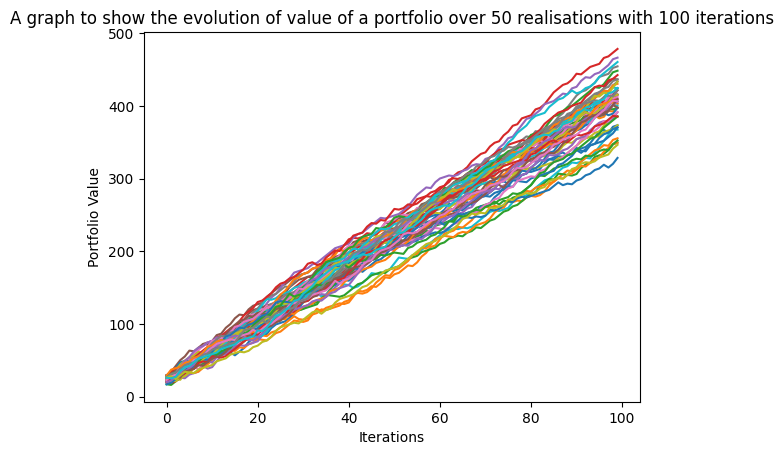

In [ ]:
#Trajectory of the portfolio value

examplePortfolio.reset()
values = []

runs = 50
iterationsPerRun = 100

for i in range(runs):
    runValues = []
    for iteration in range(iterationsPerRun):
        examplePortfolio.evolve()
        runValues.append(examplePortfolio.returnCurrentValue())
    values.append(runValues)
    examplePortfolio.reset()

for runValues in values:
    plt.plot(runValues)

plt.xlabel("Iterations")
plt.ylabel("Portfolio Value")
plt.title(f"A graph to show the evolution of value of a portfolio over {runs} realisations with {iterationsPerRun} iterations")

In [ ]:
examplePortfolio.reset()
values = []

runs = 50
iterationsPerRun = 100

for i in range(runs):
    runValues = []
    for iteration in range(iterationsPerRun):
        examplePortfolio.evolve()
        runValues.append(examplePortfolio.returnCurrentValue())
    values.append(runValues)
    examplePortfolio.reset()

for runValues in values:
    plt.plot(runValues)

plt.xlabel("Iterations")
plt.ylabel("Portfolio Value")
plt.title(f"A graph to show the evolution of value of a portfolio over {runs} realisations with {iterationsPerRun} iterations")